# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [4]:
%matplotlib inline

In [5]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

## Custom

In [6]:
import src.graphics.settings
import src.graphics.sketch
import src.graphics.models

import src.data.radioactivity
import src.data.features
import src.data.coordinates
import src.data.frequencies

import src.models.complete
import src.models.individual
import src.models.unpooled
import src.models.partial
import src.models.vi
import src.models.va
import src.models.rva
import src.models.mrva

import src.models.inference
import src.models.mapping


<br>

## Settings



Aesthetics

In [7]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures
* The `Labels` class is for `sketch.annotation(ax, Labels(title='...', xlabel='...', ylabel='...'))`

In [8]:
sketch = src.graphics.sketch.Sketch()
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

For the DAG (directed acyclic graph) of models

In [9]:
path = os.path.join(os.getcwd(), 'notebooks')
dag = src.graphics.models.Models(path=path)

<br>

Seed

In [10]:
RANDOM_SEED = 8924

<br>

## Logging

In [11]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

Excerpt: Focusing on Minnesota, MN, dwellings.

In [12]:
excerpt = src.data.radioactivity.Radioactivity().exc(state='MN')

<br>

Extra features

In [13]:
excerpt = src.data.features.Features().exc(data=excerpt)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


# of instances: (919, 29)
2022-12-10 21:43:26.655


# of unique codes: (919,)
2022-12-10 21:43:26.656



<br>

Frequencies

In [14]:
frequencies = src.data.frequencies.Frequencies().county(data=excerpt)
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-10 21:43:26.671



<br>
<br>

# Exploratory Graphs

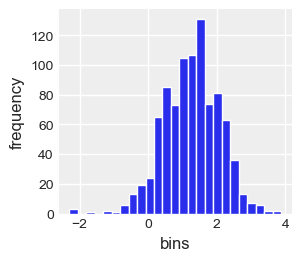

In [15]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Models

The model's initial co$\ddot{o}$rdinates

In [16]:
coords = src.data.coordinates.Coordinates(data=excerpt).exc()
logger.info(coords.keys())


dict_keys(['Level', 'County', 'ArgCholeskyDeviations', 'ArgCholeskyCorrelations'])
2022-12-10 21:43:27.641



<br>
<br>

## Complete

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*, i.e., basement or ground level.
* The dependent variable is *ln(radon)*
* Is the *intercept* implicit below?



<br>

### Model


The model

In [17]:
complete = src.models.complete.Complete(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = measures[levelcode]: (919,)
2022-12-10 21:43:29.153


y
2022-12-10 21:43:29.179



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(complete)`

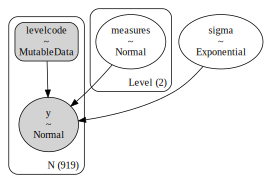

In [18]:
name = 'complete.gv'
dag.exc(model=complete, size='3.7,4.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [19]:
complete_ = src.models.inference.Inference(model=complete).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 21:43:30.589

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 21:43:30.591

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 21:43:33.895

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-10 21:43:33.898



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
2022-12-10 21:44:04.725

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-10 21:44:10.800

Sampling: [y]

Sampling: [y]
2022-12-10 21:44:10.962



In [20]:
complete_ = src.models.mapping.Mapping(inferences=complete_, coords=coords).exc()

In [21]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Prior Measures

<br>

**Prior Measures: Distributions**



In [22]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.prior['measures'].sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.head())


   measures  level      type
0  1.615587      0  Basement
1  2.820124      0  Basement
2 -2.231696      0  Basement
3 -0.724055      0  Basement
4 -4.240386      0  Basement
2022-12-10 21:44:11.982



<br>

The graph

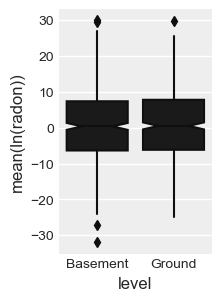

In [23]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

### Prior Predictive

In [24]:
complete_.prior_predictive

<xarray.Dataset>
Dimensions:  (chain: 1, draw: 500, N: 919)
Coordinates:
  * chain    (chain) int32 0
  * draw     (draw) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * N        (N) int32 0 1 2 3 4 5 6 7 8 ... 910 911 912 913 914 915 916 917 918
Data variables:
    y        (chain, draw, N) float64 -13.93 0.4547 2.31 ... 1.992 1.898 2.677
Attributes:
    created_at:                 2022-12-10T21:44:10.918310
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

<br>
<br>

### Posterior Measures


Notes/references:

* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`


<br>

**Posterior Measures: Distributions**

In [25]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.posterior['measures'].mean(dim=('chain')).sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.tail())


      measures  level    type
1995  0.756877      1  Ground
1996  0.865159      1  Ground
1997  0.750935      1  Ground
1998  0.759147      1  Ground
1999  0.757840      1  Ground
2022-12-10 21:44:12.433



<br>

The distributions

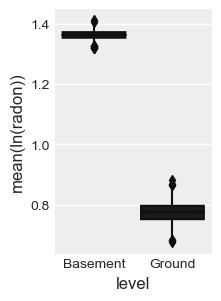

In [26]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

**Posterior Measures & Standard Deviations: Summaries**

In [27]:
az.summary(complete_)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
measures[Basement]  1.362  0.028   1.309    1.415      0.000    0.000   
measures[Ground]    0.775  0.065   0.653    0.893      0.001    0.001   
sigma               0.791  0.018   0.757    0.826      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
measures[Basement]    5774.0    2912.0    1.0  
measures[Ground]      6386.0    2934.0    1.0  
sigma                 5694.0    3080.0    1.0

<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

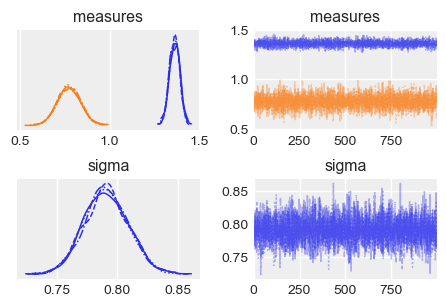

In [28]:
with complete:
    az.plot_trace(data=complete_, figsize=(4.35, 2.95))

<br>

Cf.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013815A00>,
      dtype=object)

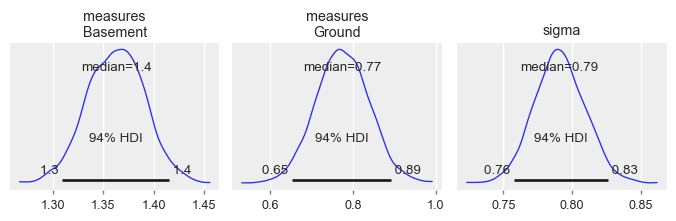

In [29]:
pm.plot_posterior(data=complete_, var_names=['measures', 'sigma'], 
                 figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

**Posterior Measures Mean**

In [30]:
averages_features = complete_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    measures   (Level) float64 1.362 0.7749
    sigma      float64 0.7909

<br>

**Posterior Measures High Density Intervals**

Herein, determining the high density posterior intervals via

> ```python
hdi_features = (
    trace.posterior['measures'].groupby(trace.posterior.LevelName).apply(
        lambda x: az.hdi(x, input_core_dims=[['chain', 'draw']]))['measures']
)
hdi_features


is unnecessarily complex, and the resulting object does not include `LevelCode` co$\ddot{o}$rdinates.

<br>


In [31]:
hdi_features = az.hdi(complete_)
hdi_features

<xarray.Dataset>
Dimensions:    (Level: 2, hdi: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
  * hdi        (hdi) <U6 'lower' 'higher'
Data variables:
    measures   (Level, hdi) float64 1.309 1.415 0.6526 0.8929
    sigma      (hdi) float64 0.7575 0.8256

<br>
<br>

### Posterior Predictive

<br>

**Posterior Predictive Check**

Equivalent:
> ```python 
pm.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

> ```python 
az.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

<br>

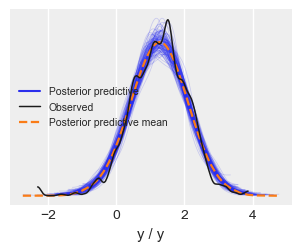

In [32]:
az.plot_ppc(data=complete_, figsize=(2.9, 2.4), num_pp_samples=125, random_seed=RANDOM_SEED, textsize=10)

<br>
<br>

**The posterior predictive high density interval per floor level type**

In [33]:
credibility = lambda x: az.hdi(x, input_core_dims=[["chain", "draw", "N"]])
hdi_predictive = (
    complete_.posterior_predictive.y.groupby(complete_.constant_data.levelcode)
    .apply(credibility)
    .y
)
hdi_predictive

<xarray.DataArray 'y' (levelcode: 2, hdi: 2)>
array([[-0.12488312,  2.85286899],
       [-0.71681857,  2.27509127]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * levelcode  (levelcode) int64 0 1

<br>

### Graphs

<br>

**High Density Intervals, Averages**

Options:

* `sns.scatterplot(y=complete_.observed_data['y'], x=trace.observed_data['LevelName'], ax=ax)`

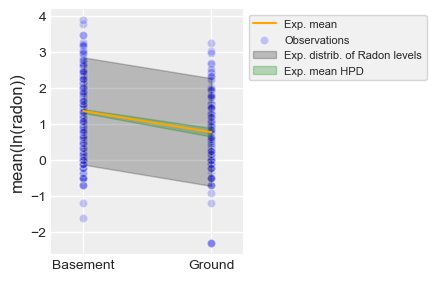

In [34]:
ax = sketch.figure(width=4.25, height=2.7)

complete_.observed_data.plot.scatter(x='LevelCode', y='y', label='Observations', alpha=0.25, ax=ax)

az.plot_hdi(hdi_predictive.levelcode.values, 
            hdi_data=hdi_predictive, 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. distrib. of Radon levels'}, 
            color='k',
            ax=ax)

az.plot_hdi(hdi_features.LevelCode.values, 
            hdi_data=hdi_features['measures'], 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. mean HPD'}, 
            color='green',
            ax=ax)

ax.plot(np.arange(averages_features.coords['Level'].shape[0]), 
        averages_features['measures'].values, 
        color='orange',
        label='Exp. mean')

sketch.annotation(ax, Labels(title='', xlabel='', ylabel='mean(ln(radon))'))

ax.set_xlim(-0.25, 1.25)

ax.set_xticks(complete_.posterior['LevelCode'].values)
ax.set_xticklabels(complete_.posterior['Level'].values, rotation=0)

ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(1, 1), loc='upper left')

<br>
<br>

**Clean-up**

In [35]:
del hdi_features, averages_features, hdi_predictive

<br>

### Inference Data

In [36]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

## Individual

### Model

In [37]:
individual = src.models.individual.Individual(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-10 21:44:20.954



<br>

An <span style='color: #808080'>illustration</span> of the model

* Similarly: `pm.model_to_graphviz(individual)`

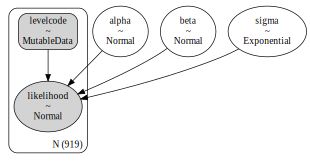

In [38]:
name = 'individual.gv'
dag.exc(model=individual, size='4.3,4.0', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [39]:
individual_ = src.models.inference.Inference(model=individual).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 21:44:22.340

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 21:44:22.343

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 21:44:25.801

NUTS: [alpha, beta, sigma]

NUTS: [alpha, beta, sigma]
2022-12-10 21:44:25.802



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
2022-12-10 21:44:56.093

Sampling: [alpha, beta, likelihood, sigma]

Sampling: [alpha, beta, likelihood, sigma]
2022-12-10 21:45:02.030

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 21:45:02.208



In [40]:
individual_.posterior = individual_.posterior.assign_coords(Level=list(coords['Level'].keys()))
individual_ = src.models.mapping.Mapping(inferences=individual_, coords=coords).exc()

<br>
<br>

### Posterior Measures

<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

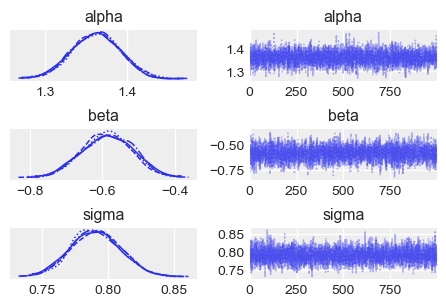

In [41]:
with individual:
    az.plot_trace(data=individual_, figsize=(4.35, 2.95)) 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E32C520>,
      dtype=object)

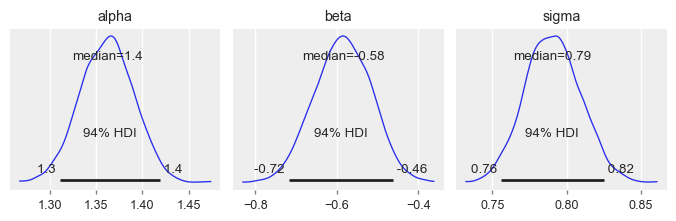

In [42]:
pm.plot_posterior(data=individual_, var_names=['alpha', 'beta', 'sigma'], 
                  figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)   

<br>

**Posterior Measures Mean**

In [43]:
individual_.posterior.mean(dim=('chain', 'draw'))

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    alpha      float64 1.362
    beta       float64 -0.5855
    sigma      float64 0.7909

<br>
<br>

## Unpooled

<br>

The object `coords` has the set of distinct counties, each has a distinct index; ref. `coords['County']`.  &nbsp; In future use [an appropriate geographic code](https://www.nist.gov/system/files/documents/2021/08/11/FIPSCodesReplacementChart2015.pdf). &nbsp;  Additionally, the data object `excerpt` includes a `countyindex` field, whereby the relevant dictionary is $\rightarrow$ `coords['County']`.

> ```python
logger.info(coords.keys())
logger.info(coords.get('County'))
```


<br>

### Model

In [44]:
unpooled = src.models.unpooled.Unpooled(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = measures[countyindex, levelcode]: (919,)
2022-12-10 21:45:07.960


y
2022-12-10 21:45:07.979



<br>
<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(unpooled)`

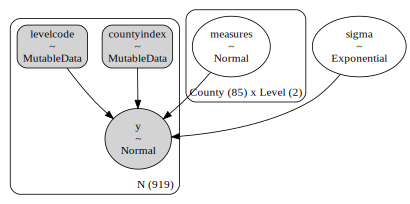

In [45]:
name = 'unpooled.gv'
dag.exc(model=unpooled, size='5.7,5.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [46]:
unpooled_ = src.models.inference.Inference(model=unpooled).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 21:45:09.128

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 21:45:09.129

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 21:45:12.502

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-10 21:45:12.504



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.
2022-12-10 21:46:05.170

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-10 21:46:12.018

Sampling: [y]

Sampling: [y]
2022-12-10 21:46:12.199



In [47]:
unpooled_ = src.models.mapping.Mapping(inferences=unpooled_, coords=coords).exc()

In [48]:
unpooled_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Posterior Measures & Standard Deviations: Summaries**

In [49]:
az.summary(unpooled_)

mean      sd  hdi_3%  hdi_97%  \
measures[AITKIN, Basement]           0.673   0.407  -0.097    1.431   
measures[AITKIN, Ground]             0.824   0.707  -0.494    2.167   
measures[ANOKA, Basement]            0.956   0.100   0.764    1.138   
measures[ANOKA, Ground]             -0.122   0.428  -0.943    0.651   
measures[BECKER, Basement]           1.462   0.706   0.141    2.770   
...                                    ...     ...     ...      ...   
measures[WRIGHT, Basement]           1.676   0.211   1.303    2.078   
measures[WRIGHT, Ground]             0.879   0.703  -0.436    2.188   
measures[YELLOW MEDICINE, Basement]  1.222   0.499   0.304    2.151   
measures[YELLOW MEDICINE, Ground]   -0.149  10.065 -19.053   19.091   
sigma                                0.717   0.018   0.682    0.750   

                                     mcse_mean  mcse_sd  ess_bulk  ess_tail  \
measures[AITKIN, Basement]               0.006    0.005    4778.0    2798.0   
measures[AITKIN, Ground]                 0.010    0.008    4692.0    2572.0   
measures[ANOKA, Basement]                0.001    0.001    4634.0    2956.0   
measures[ANOKA, Ground]                  0.006    0.007    4794.0    2657.0   
measures[BECKER, Basement]               0.011    0.008    4160.0    2557.0   
...                                        ...      ...       ...       ...   
measures[WRIGHT, Basement]               0.003    0.002    5258.0    2511.0   
measures[WRIGHT, Ground]                 0.010    0.009    4780.0    2737.0   
measures[YELLOW MEDICINE, Basement]      0.008    0.006    4302.0    2865.0   
measures[YELLOW MEDICINE, Ground]        0.147    0.162    4661.0    2924.0   
sigma                                    0.000    0.000    3617.0    2447.0   

                                     r_hat  
measures[AITKIN, Basement]             1.0  
measures[AITKIN, Ground]               1.0  
measures[ANOKA, Basement]              1.0  
measures[ANOKA, Ground]                1.0  
measures[BECKER, Basement]             1.0  
...                                    ...  
measures[WRIGHT, Basement]             1.0  
measures[WRIGHT, Ground]               1.0  
measures[YELLOW MEDICINE, Basement]    1.0  
measures[YELLOW MEDICINE, Ground]      1.0  
sigma                                  1.0  

[171 rows x 9 columns]

<br>

<br>

**Posterior Measures & Standard Deviations: Graphs**

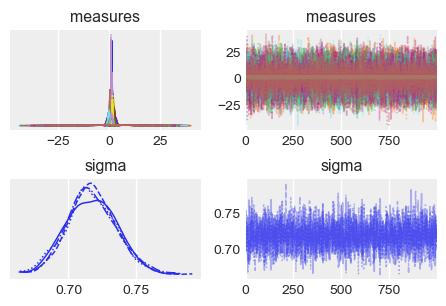

In [50]:
with unpooled:
    az.plot_trace(data=unpooled_, figsize=(4.35, 2.95))

<br>
<br>

**Posterior Measures: High Density Intervals**

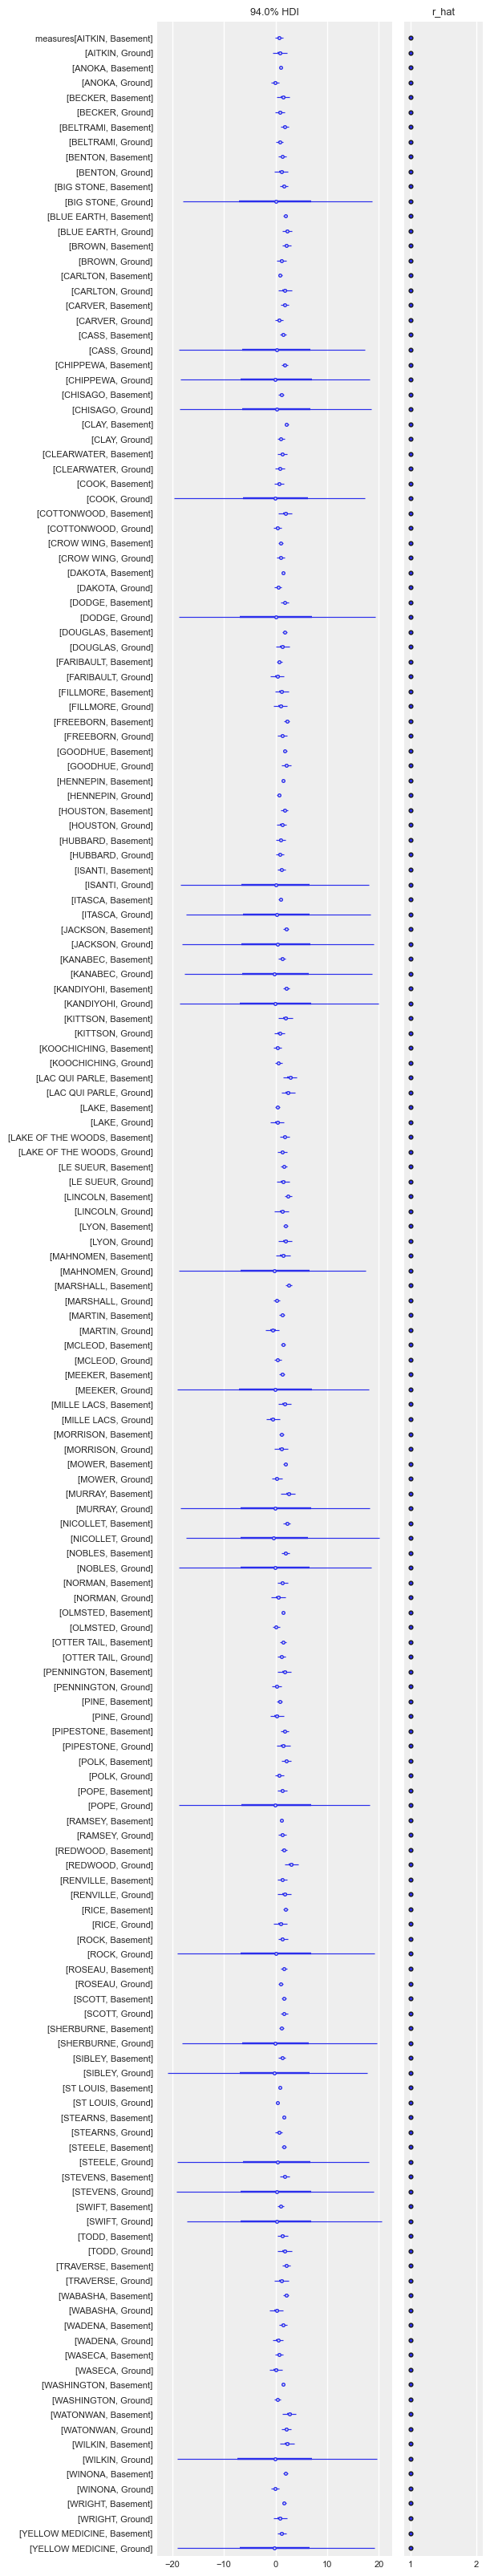

In [51]:
az.plot_forest(
    unpooled_, var_names='measures', figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

<br>

**Posterior Mean**

In [52]:
averages_features = unpooled_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
Data variables:
    measures     (County, Level) float64 0.6725 0.8237 0.9556 ... 1.222 -0.1494
    sigma        float64 0.7172

<br>

**Posterior Check**

In [53]:
hdi_features = az.hdi(unpooled_)
hdi_features

<xarray.Dataset>
Dimensions:      (County: 85, Level: 2, hdi: 2, LevelCode: 2, CountyIndex: 85)
Coordinates:
  * County       (County) <U17 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'
  * Level        (Level) <U8 'Basement' 'Ground'
  * LevelCode    (LevelCode) int32 0 1
  * CountyIndex  (CountyIndex) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * hdi          (hdi) <U6 'lower' 'higher'
Data variables:
    measures     (County, Level, hdi) float64 -0.09703 1.431 ... -19.05 19.09
    sigma        (hdi) float64 0.6817 0.7504

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages**

For more about `sel(.)` visit [arviz.InferenceData.sel(.)](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.sel.html).  &nbsp; The # of counties is

> ```python 
len(coords.get('County'))


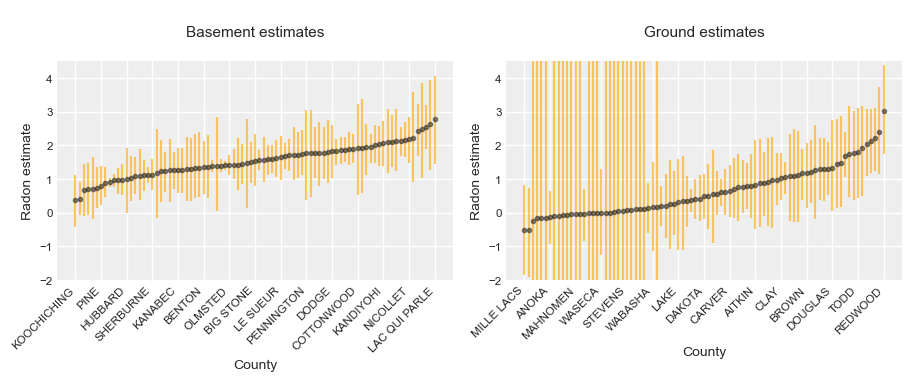

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.7))

xticks = np.arange(0, 86, 6)

fontdict = {'horizontalalignment': 'right', 'fontsize': 8}

for ax, level in zip(axes, ['Basement', 'Ground']):
    
    averages_ = averages_features.sel(Level=level).sortby('measures')
    
    # the HDI limits per County ordered by increasing average, i.e., as above
    hdi_ = hdi_features.sel(Level=level).sortby(averages_.measures)
    
    # the scatter plot of the average value per County
    ax.plot(averages_['County'].values, averages_['measures'].values, 'ok', markersize=3, alpha=0.5);
    
    # high density interval lines
    ax.vlines(
        np.arange(len(coords.get('County'))),
        hdi_.measures.sel(hdi='lower'),
        hdi_.measures.sel(hdi='higher'),
        color='orange',
        alpha=0.6,
    )    
    
    # titles
    ax.set_title(f'\n{level.title()} estimates\n', fontsize=11)
    
    # x ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(averages_.County.values[xticks], horizontalalignment='right', rotation=45)
    
    # all ticks
    ax.tick_params(labelsize='x-small')
    
    # limits
    ax.set_ylim(bottom=-2, top=4.5)
    
    # labels
    ax.set_xlabel('County', fontsize=10)
    ax.set_ylabel('Radon estimate', fontsize=10)
    

<br>
<br>

**Ground Level Dispersions of High Density Intervals**

Ground level posterior `measures`  high density interval data

In [55]:
experiment = hdi_features['measures'].sel(Level='Ground')

<br>

Hence, the differences and their parallel county names

In [56]:
differences = pd.DataFrame(data={'difference': experiment.sel(hdi='higher') - experiment.sel(hdi='lower'), 
                                 'county': experiment['County']})

<br>

Differences and frequencies.

In [57]:
values = frequencies.loc[frequencies['floor'] == coords['Level']['Ground'], ]
dispersions = differences.merge(values, how='left', on='county')
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.970188         WATONWAN         80.0    1.0  2.0
81   38.712147           WILKIN          NaN    NaN  NaN
82    1.524712           WINONA         82.0    1.0  3.0
83    2.624088           WRIGHT         83.0    1.0  1.0
84   38.143958  YELLOW MEDICINE          NaN    NaN  NaN
2022-12-10 21:46:47.617



<br>

Some counties do not have any ground level data points

In [58]:
dispersions.loc[:, 'N'] = dispersions['N'].fillna(value=0).array
logger.info(dispersions.tail())


    difference           county  countyindex  floor    N
80    1.970188         WATONWAN         80.0    1.0  2.0
81   38.712147           WILKIN          NaN    NaN  0.0
82    1.524712           WINONA         82.0    1.0  3.0
83    2.624088           WRIGHT         83.0    1.0  1.0
84   38.143958  YELLOW MEDICINE          NaN    NaN  0.0
2022-12-10 21:46:47.630



<br>

The graph below illustrates that the large dispersions, intervals, are due counties that do not have data points.

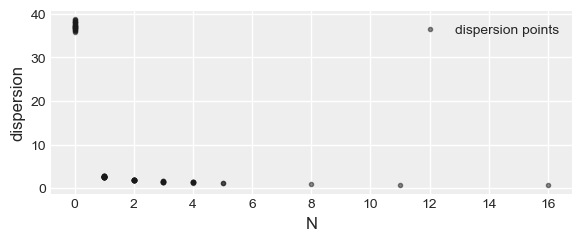

In [59]:
ax = sketch.figure(width=5.7, height=2.3)

ax.plot(dispersions['N'].array, dispersions['difference'].array, 'ok', markersize=3, alpha=0.5, label='dispersion points');
sketch.annotation(ax, Labels(title='', xlabel='N', ylabel='dispersion'))
ax.legend(loc='upper right', fontsize='small');

<br>
<br>

**Funnel**

Upcoming

<br>
<br>

**Estimates**

Upcoming

In [60]:
averages_features['measures'].sel(County='AITKIN')

<xarray.DataArray 'measures' (Level: 2)>
array([0.67254256, 0.82374956])
Coordinates:
    County   <U17 'AITKIN'
  * Level    (Level) <U8 'Basement' 'Ground'

In [61]:
unpooled_.observed_data['y'][unpooled_.observed_data.coords['County'] == 'AITKIN']

<xarray.DataArray 'y' (N: 4)>
array([0.83290912, 1.09861229, 0.09531018, 0.83290912])
Coordinates:
  * N            (N) int32 1 2 3 0
    Level        (N) <U8 'Basement' 'Basement' 'Basement' 'Ground'
    LevelCode    (N) int32 0 0 0 1
    County       (N) <U17 'AITKIN' 'AITKIN' 'AITKIN' 'AITKIN'
    CountyIndex  (N) int32 0 0 0 0

<br>
<br>

**Clean-up**

In [62]:
del hdi_features, hdi_, averages_features, averages_

<br>
<br>

### Inference Data

In [63]:
unpooled_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>
<br>

## Partial

### Model

In [64]:
partial = src.models.partial.Partial(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex]: (919,)
2022-12-10 21:46:48.902


likelihood
2022-12-10 21:46:48.921



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(partial)`

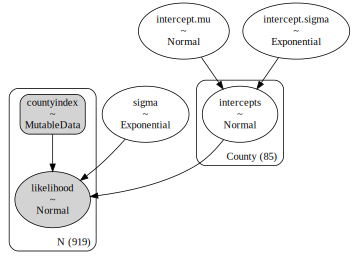

In [65]:
name = 'partial.gv'
dag.exc(model=partial, size='4.9,4.1', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [66]:
partial_ = src.models.inference.Inference(model=partial).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 21:46:50.547

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 21:46:50.549

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 21:46:55.306

NUTS: [intercept.mu, intercept.sigma, intercepts, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, sigma]
2022-12-10 21:46:55.308



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
2022-12-10 21:47:35.736

Sampling: [intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-10 21:47:42.436

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 21:47:42.629



In [67]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

Enrich

In [68]:
partial_ = src.models.mapping.Mapping(inferences=partial_, coords=coords).exc()

In [69]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Preliminaries**

The frequencies

In [70]:
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-10 21:47:43.843



<br>

Tallies by county only.

In [71]:
T = frequencies.groupby(by=['county', 'countyindex']).agg(N=('N', sum))
T.reset_index(drop=False, inplace=True)
K = T.copy().set_index(keys='countyindex')

logger.info(T.tail())
logger.info(K.tail())


             county  countyindex   N
80         WATONWAN           80   3
81           WILKIN           81   1
82           WINONA           82  13
83           WRIGHT           83  13
84  YELLOW MEDICINE           84   2
2022-12-10 21:47:43.871


                      county   N
countyindex                     
80                  WATONWAN   3
81                    WILKIN   1
82                    WINONA  13
83                    WRIGHT  13
84           YELLOW MEDICINE   2
2022-12-10 21:47:43.875



<br>

Extra co${\ddot{o}}$rdinates



> ```python 
indices[-5:]


In [72]:
indices = partial_.posterior.coords['CountyIndex'].values

In [73]:
partial_.posterior = partial_.posterior.assign_coords({'Tally': ('County', K.iloc[indices, :]['N'].array)})

In [74]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

**Posterior Mean**

In [75]:
averages_features = partial_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:          (County: 85, CountyIndex: 85)
Coordinates:
  * County           (County) <U17 'AITKIN' 'ANOKA' ... 'YELLOW MEDICINE'
  * CountyIndex      (CountyIndex) int32 0 1 2 3 4 5 6 ... 78 79 80 81 82 83 84
    Tally            (County) int64 4 52 3 7 4 3 14 4 10 ... 5 4 46 3 1 13 13 2
Data variables:
    intercept.mu     float64 1.348
    intercepts       (County) float64 1.11 0.9414 1.267 ... 1.444 1.52 1.313
    intercept.sigma  float64 0.3002
    sigma            float64 0.7672

<br>

**Posterior Check**

In [76]:
hdi_features = az.hdi(partial_)
hdi_features

<xarray.Dataset>
Dimensions:          (hdi: 2, County: 85, CountyIndex: 85)
Coordinates:
  * County           (County) <U17 'AITKIN' 'ANOKA' ... 'YELLOW MEDICINE'
  * CountyIndex      (CountyIndex) int32 0 1 2 3 4 5 6 ... 78 79 80 81 82 83 84
    Tally            (County) int64 4 52 3 7 4 3 14 4 10 ... 5 4 46 3 1 13 13 2
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    intercept.mu     (hdi) float64 1.26 1.44
    intercepts       (County, hdi) float64 0.6418 1.573 0.7557 ... 0.8556 1.815
    intercept.sigma  (hdi) float64 0.2179 0.3892
    sigma            (hdi) float64 0.735 0.8035

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages,Tallies**

County tally, posterior mean, and high density interval.  `Either`

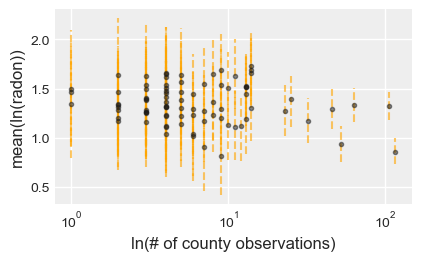

In [77]:
ax = sketch.figure(width=4.1, height=2.5)

# scatter plot
ax.plot(averages_features.coords['Tally'].values, averages_features['intercepts'].values, 'ok', markersize=3, alpha=0.5);

# high density interval lines
ax.vlines(
    hdi_features.coords['Tally'].values,
    hdi_features['intercepts'].sel(hdi='lower').values,
    hdi_features['intercepts'].sel(hdi='higher').values,
    color='orange',
    linestyles='dashed',
    alpha=0.6,
)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>

`Or`

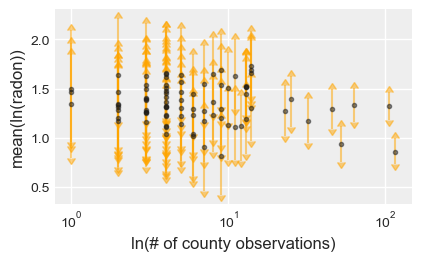

In [78]:
ax = sketch.figure(width=4.1, height=2.5)

# limits
X = np.concatenate((np.expand_dims(hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values, axis=0)))

points = averages_features['intercepts'].values
Y = np.concatenate((np.expand_dims(points - hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values - points, axis=0)))

# graph
ax.errorbar(averages_features.coords['Tally'].values, 
            averages_features['intercepts'].values, 
            Y, 
            uplims=True, lolims=True,
            ecolor='orange', 
            marker='o', markersize=3, markerfacecolor='k', markeredgecolor='k', 
            linestyle='',
            alpha=0.5)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>
<br>

**Clean-up**

In [79]:
del X, Y, hdi_features, averages_features

<br>
<br>

### Inference Data

In [80]:
partial_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>
<br>

## Varying Intercept

### Model

In [81]:
vi = src.models.vi.VI(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The shape of mu, whereby mu = intercepts[countyindex] + (beta * levelcode): (919,)
2022-12-10 21:47:50.391


likelihood
2022-12-10 21:47:50.410



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(vi)`

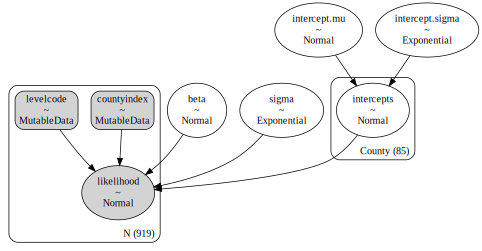

In [82]:
name = 'vi.gv'
dag.exc(model=vi, size='6.7,5.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [83]:
vi_ = src.models.inference.Inference(model=vi).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 21:47:52.298

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 21:47:52.299

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 21:47:57.615

NUTS: [intercept.mu, intercept.sigma, intercepts, beta, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, beta, sigma]
2022-12-10 21:47:57.617



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
2022-12-10 21:48:38.589

Sampling: [beta, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [beta, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-10 21:48:45.370

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 21:48:45.631



In [84]:
vi_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Posterior Measures

<br>

**Summary**: The mean & deviation of the random intercepts, the common gradient $\beta$, the deviation $\sigma$ of the model's error

In [85]:
az.summary(vi_, var_names=['intercept.mu', 'intercept.sigma', 'beta', 'sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept.mu     1.493  0.049   1.400    1.582      0.001    0.001    1788.0   
intercept.sigma  0.316  0.044   0.234    0.400      0.001    0.001     965.0   
beta            -0.663  0.067  -0.792   -0.537      0.001    0.001    2815.0   
sigma            0.727  0.018   0.693    0.759      0.000    0.000    4618.0   

                 ess_tail  r_hat  
intercept.mu       2860.0    1.0  
intercept.sigma    1115.0    1.0  
beta               2851.0    1.0  
sigma              3270.0    1.0

<br>
<br>

**Graphs**: The mean & deviation of the random intercepts, the common gradient $\beta$, the deviation $\sigma$ of the model's error

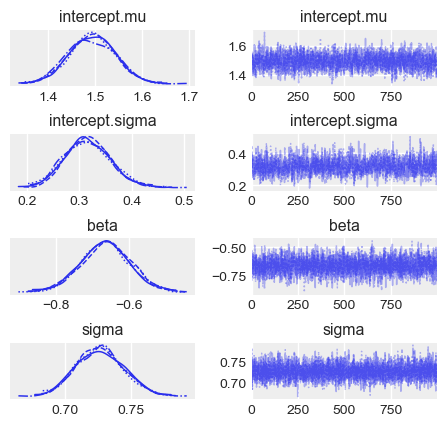

In [86]:
with vi:
    az.plot_trace(data=vi_, var_names=['intercept.mu', 'intercept.sigma', 'beta', 'sigma'], 
                 figsize=(4.35, 4.15))

<br>

Cf.

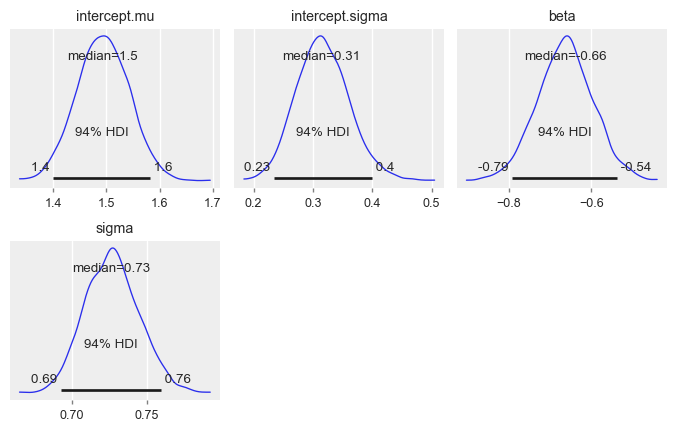

In [87]:
pm.plot_posterior(data=vi_, var_names=['intercept.mu', 'intercept.sigma', 'beta', 'sigma'], 
                 figsize=(6.65, 4.2), grid=(2, 3), point_estimate='median', textsize=9);

<br>
<br>

## Varying Intercept, Varying Gradient


$y_{_{i}} = \alpha_{_{i, j}} + \beta_{_{i, j}}x_{_{i}} + \epsilon_{_{i}}$

where 

> $i = 1, \ldots, N$
>
> $j = 1, \ldots, J$

and

> $\mathbf{\epsilon} \sim \mathcal{N}(0, \sigma^{\tiny{2}}_{_{y}}\mathbf{I})$

$i$ denotes the observation unit, there are $N$ observations. $\alpha_{_{i,j}}$ is the varying intercept term, and $\beta_{_{i,j}}$ is the varying gradient term, such that unit $i$ is a member of group $j$; there are $J$ groups.

In [88]:
va = src.models.va.VA(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-10 21:48:54.630



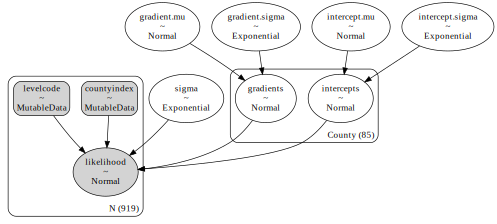

In [89]:
name = 'va.gv'
dag.exc(model=va, size='6.9,5.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

In [90]:
va_ = src.models.inference.Inference(model=va).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 21:48:57.562

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 21:48:57.565

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 21:49:05.799

NUTS: [intercept.mu, intercept.sigma, intercepts, gradient.mu, gradient.sigma, gradients, sigma]

NUTS: [intercept.mu, intercept.sigma, intercepts, gradient.mu, gradient.sigma, gradients, sigma]
2022-12-10 21:49:05.801



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.
2022-12-10 21:50:33.607

Sampling: [gradient.mu, gradient.sigma, gradients, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]

Sampling: [gradient.mu, gradient.sigma, gradients, intercept.mu, intercept.sigma, intercepts, likelihood, sigma]
2022-12-10 21:50:41.114

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 21:50:41.399



In [91]:
va_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

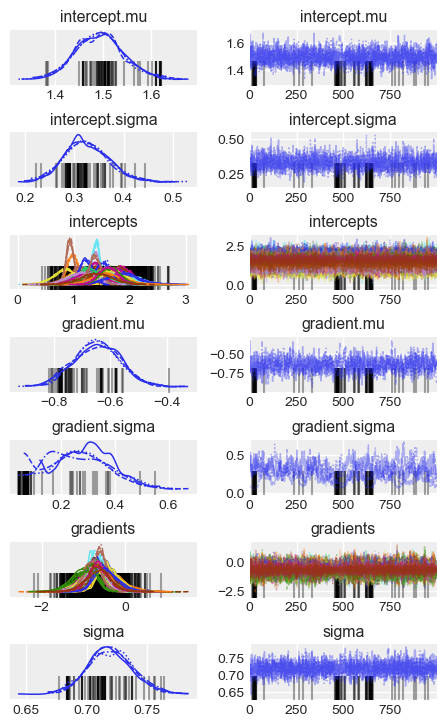

In [92]:
with va:
    az.plot_trace(data=va_, var_names=['intercept.mu', 'intercept.sigma', 'intercepts', 
                                       'gradient.mu', 'gradient.sigma', 'gradients', 'sigma'], 
                 figsize=(4.35, 7.15))

<br>
<br>

## Varying Intercept, Varying Gradient, Non-centred Parameterisation

In [93]:
rva = src.models.rva.RVA(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-10 21:51:15.759



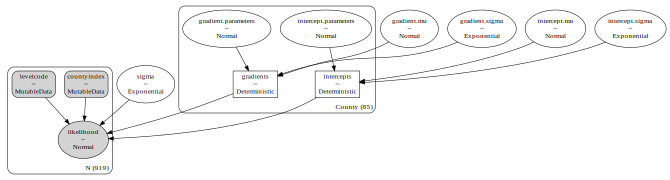

In [94]:
name = 'rva.gv'
dag.exc(model=rva, size='9.3,8.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

In [95]:
rva_ = src.models.inference.Inference(model=rva).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-10 21:51:18.661

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-10 21:51:18.663

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-10 21:51:25.185

NUTS: [intercept.mu, intercept.sigma, intercept.parameters, gradient.mu, gradient.sigma, gradient.parameters, sigma]

NUTS: [intercept.mu, intercept.sigma, intercept.parameters, gradient.mu, gradient.sigma, gradient.parameters, sigma]
2022-12-10 21:51:25.187



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
2022-12-10 21:52:37.599

Sampling: [gradient.mu, gradient.parameters, gradient.sigma, intercept.mu, intercept.parameters, intercept.sigma, likelihood, sigma]

Sampling: [gradient.mu, gradient.parameters, gradient.sigma, intercept.mu, intercept.parameters, intercept.sigma, likelihood, sigma]
2022-12-10 21:52:45.411

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-10 21:52:45.718



In [96]:
rva_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

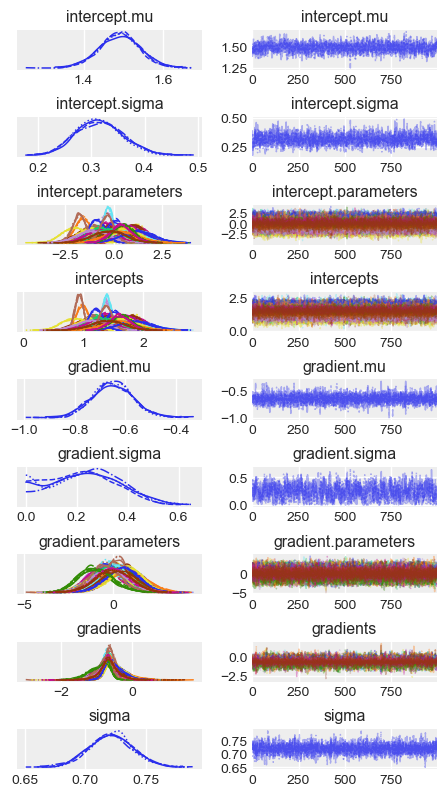

In [97]:
with rva:
    az.plot_trace(data=rva_, var_names=['intercept.mu', 'intercept.sigma', 'intercept.parameters', 'intercepts', 
                                       'gradient.mu', 'gradient.sigma', 'gradient.parameters', 'gradients', 
                                       'sigma'], 
                 figsize=(4.35, 7.85))

<br>
<br>

## Varying Intercept, Varying Gradient, Non-centred Parameterisation, MVN

In [ ]:
mrva = src.models.mrva.MRVA(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)

In [ ]:
name = 'mrva.gv'
dag.exc(model=mrva, size='9.3,8.9', name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>
<br>

# Clean-up

In [ ]:
os.getcwd()

<br>

The cleaning-up scripts, in relation to the current directory.

In [ ]:
%%bash

# The list of files in directory notebooks/
ls -l notebooks/

# Deleting the directed acyclic graphs of the models
rm -rf notebooks/*.gv
rm -rf notebooks/*.gv.pdf

# Inspect notebooks
ls -l notebooks/

